### Introduction to Uncertainty Quantification with TF Probability (Part 1)
* In this notebook, we will introduce the concept of uncertainty quantification when doing image classification using the MNIST dataset.
* We will start with a classic CNN.
* We will introduce a `OneHotCategorical()` layer to account for aleatoric uncertainties. These type of uncertainities are those inherint in the data


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow_datasets as tfds

# TensorFlow Probability 
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

/Users/aaronhiguera/anaconda3/envs/tf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(tf.__version__)
print(tfp.__version__)

2.14.0
0.22.0


* Load MNIST dataset

In [3]:
train_ds, test_ds = tfds.load('mnist', split = ['train', 'test'], as_supervised = True)

2024-06-18 12:39:11.500128: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-18 12:39:11.500153: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-06-18 12:39:11.500158: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-06-18 12:39:11.500182: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-18 12:39:11.500194: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


* Normalize image and do one hot encoding for the classes 

In [4]:
def ohe_normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images = tf.divide(images, 255.0)
    labels = tf.one_hot(labels, 10)
    return images, labels

train_ds = train_ds.batch(64).map(ohe_normalize).shuffle(64) \
          .prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(64).map(ohe_normalize) \
          .prefetch(tf.data.AUTOTUNE)

* Create a simple CNN to classify the images

In [5]:
model = Sequential(name='CNN')

# First convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Dense layer for classification
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [6]:
model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 1152)              0       

In [7]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
history = model.fit(train_ds, epochs = 15, validation_data = test_ds)

Epoch 1/15


2024-06-18 12:39:12.088781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 17s 16ms/step - loss: 0.4828 - accuracy: 0.8662 - val_loss: 0.1472 - val_accuracy: 0.9588
Epoch 2/15
938/938 [==============================] - 15s 16ms/step - loss: 0.1322 - accuracy: 0.9611 - val_loss: 0.0947 - val_accuracy: 0.9724
Epoch 3/15
938/938 [==============================] - 15s 16ms/step - loss: 0.0925 - accuracy: 0.9720 - val_loss: 0.0647 - val_accuracy: 0.9808
Epoch 4/15
938/938 [==============================] - 15s 15ms/step - loss: 0.0749 - accuracy: 0.9775 - val_loss: 0.0609 - val_accuracy: 0.9801
Epoch 5/15
938/938 [==============================] - 15s 16ms/step - loss: 0.0643 - accuracy: 0.9803 - val_loss: 0.0480 - val_accuracy: 0.9848
Epoch 6/15
938/938 [==============================] - 14s 15ms/step - loss: 0.0559 - accuracy: 0.9831 - val_loss: 0.0474 - val_accuracy: 0.9844
Epoch 7/15
938/938 [==============================] - 14s 15ms/step - loss: 0.0495 - accuracy: 0.9849 - val_loss: 0.0398 - val_accuracy: 0.9863
Epo

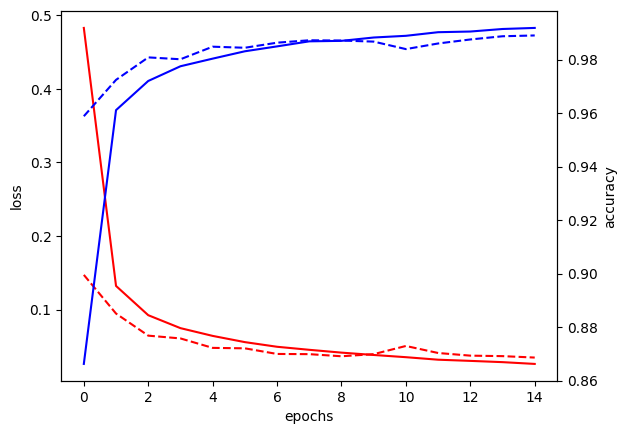

In [9]:
fig, ax1 = plt.subplots()

ax1.set_ylabel('loss', )
ax1.plot(model.history.history['loss'], 'r', label='training')
ax1.plot(model.history.history['val_loss'], 'r--', label='validation')
ax1.set_xlabel('epochs')

ax2 = ax1.twinx()
ax2.set_ylabel('accuracy', )
ax2.plot(model.history.history['accuracy'], 'b', label='training')
ax2.plot(model.history.history['val_accuracy'], 'b--', label='validation')

ax2.set_xlabel('epochs')
plt.show()

* Now make some prediction based on the model we trained 

In [10]:
example_images = []
example_labels = []

for x, y in test_ds.take(10):
    example_images.append(x.numpy())
    example_labels.append(y.numpy())

example_images = np.concatenate(example_images, axis = 0)    
example_labels = np.concatenate(example_labels, axis = 0)    

* plot prediction along with image 

In [11]:
pred = model.predict(example_images, verbose=0)

In [12]:
pred2 = model.predict(example_images, verbose=0)

Noticed that regarding how many predictions are made the values are going to be the same always
this is becuase the model is deterministic

In [13]:
(pred == pred2).all()

True

In [14]:
def plot(image, pred):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]}) 
    ax1.imshow(image, cmap='binary')
    ax2.set_xlim(0,9)
    ax2.set_ylim(0,1)
    ax2.plot(np.arange(10), pred, 'o')
    plt.show()

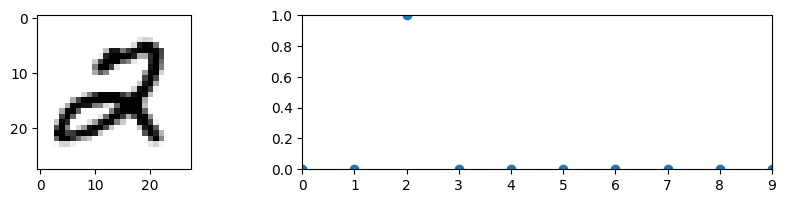

Max value 0.9999985694885254 correspond to this class [2]


In [15]:
plot(example_images[0], pred[0])
print(f'Max value {max(pred[0])} correspond to this class {np.where(pred[0] == max(pred[0]))[0]}')

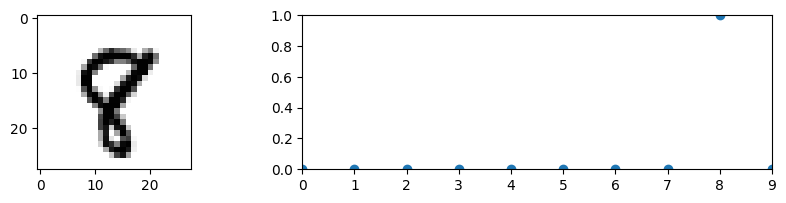

Max value 0.9994887113571167 correspond to this class [8]


In [16]:
plot(example_images[122], pred[122])
print(f'Max value {max(pred[122])} correspond to this class {np.where(pred[122] == max(pred[122]))[0]}')

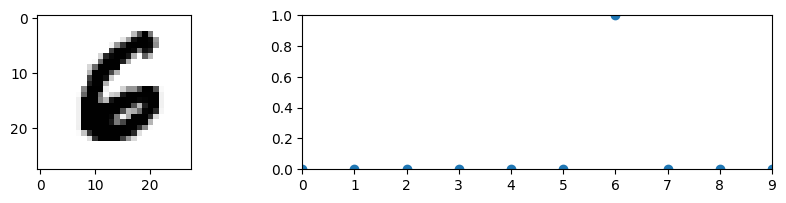

Max value 0.9999974966049194 correspond to this class [6]


In [17]:
plot(example_images[5], pred[5])
print(f'Max value {max(pred[5])} correspond to this class {np.where(pred[5] == max(pred[5]))[0]}')

* Add some noise to an image and see how the model predicts

In [18]:
noise_vector = np.random.uniform(size = (28, 28, 1), 
                                 low = 0, high = 0.5)
noisy_image = np.clip(example_images[0] + noise_vector*2, 0, 1)

* In the last example the model predicts the highest value for class 8
* How can we quantifiy the uncertainity on this prediction?
* In order to introduce uncertainties lets use `OneHotCategorical()` layer from TensorFlow Probability
`OneHotCategorical()` is designed for handling categorical distributions, this layer outputs a one-hot encoded representation of categorical data. Essentially, it can be used to parameterize a categorical distribution, where the output represents the probability of each category. The output of `OneHotCategorical()` is a probability distribution over the categorical classes. <br>
An important aspect is to explain the difference between and a `Dense()` layer with `softmax` which is often refered as the probability of a given class. Unlike `OneHotCategorical()`, this setup is deterministic. It provides the most probable class based on the learned weights, but it doesn't model the distribution of the classes. <br>
* Now let's introduce `OneHotCategorical()` into our CNN

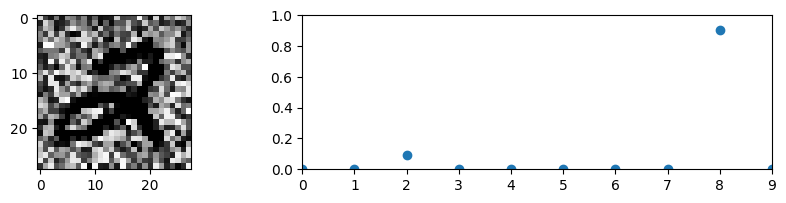

Max value 0.9014920592308044 correspond to this class [8]


In [19]:
pred_wn = model.predict(noisy_image.reshape(1,28,28,1), verbose=0)
plot(noisy_image, pred_wn[0])
print(f'Max value {max(pred_wn[0])} correspond to this class {np.where(pred_wn[0] == max(pred_wn[0]))[0]}')

In [20]:
model_wUnc = Sequential(name='CNN_withOneHotCat')

# First convolutional layer
model_wUnc.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_wUnc.add(MaxPooling2D((2, 2)))

# Second convolutional layer
model_wUnc.add(Conv2D(64, (3, 3), activation='relu'))
model_wUnc.add(MaxPooling2D((2, 2)))

# Third convolutional layer
model_wUnc.add(Conv2D(128, (3, 3), activation='relu'))

# Flatten the output of the convolutional layers
model_wUnc.add(Flatten())

# Dense layer for classification with TensorFlow Probability 
model_wUnc.add(Dense(tfpl.OneHotCategorical.params_size(10)))  
model_wUnc.add(tfpl.OneHotCategorical(10))


In [21]:
model_wUnc.summary()

Model: "CNN_withOneHotCat"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 1152)        

In [37]:
def nll(y_true, y_pred):
    """
    The negative log-likelihood (nll) of a sample y_true given a predicted distribution y_pred 
    It's a way of assessing how well the predicted distribution aligns with the actual data.
    By taking the negative of the log-likelihood, the measure is turned into a loss: higher values of this
    loss correspond to worse predictions (i.e., the true data being less likely under the predicted distribution).
    Minimizing NLL is equivalent to maximizing the likelihood of the observed data under the model's predicted distribution.
    If y_pred predicts a high probability for y_true, log_prob(y_true) will be less negative, resulting in a lower NLL loss. 
    Conversely, if y_pred predicts a low probability for y_true, log_prob(y_true) will be more negative, resulting in a higher NLL loss.
    """
    return -y_pred.log_prob(y_true)

In [23]:
model_wUnc.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = 1e-4),
              loss=nll,
              metrics=['accuracy'])

In [24]:
history = model_wUnc.fit(train_ds, epochs = 15, validation_data = test_ds)

Epoch 1/15
938/938 [==============================] - 17s 18ms/step - loss: 0.5567 - accuracy: 0.7242 - val_loss: 0.1741 - val_accuracy: 0.9026
Epoch 2/15
938/938 [==============================] - 17s 18ms/step - loss: 0.1471 - accuracy: 0.9198 - val_loss: 0.0990 - val_accuracy: 0.9407
Epoch 3/15
938/938 [==============================] - 17s 18ms/step - loss: 0.1008 - accuracy: 0.9456 - val_loss: 0.0757 - val_accuracy: 0.9612
Epoch 4/15
938/938 [==============================] - 15s 16ms/step - loss: 0.0810 - accuracy: 0.9564 - val_loss: 0.0662 - val_accuracy: 0.9596
Epoch 5/15
938/938 [==============================] - 15s 16ms/step - loss: 0.0690 - accuracy: 0.9640 - val_loss: 0.0510 - val_accuracy: 0.9708
Epoch 6/15
938/938 [==============================] - 16s 17ms/step - loss: 0.0613 - accuracy: 0.9669 - val_loss: 0.0532 - val_accuracy: 0.9711
Epoch 7/15
938/938 [==============================] - 17s 18ms/step - loss: 0.0542 - accuracy: 0.9707 - val_loss: 0.0433 - val_accuracy:

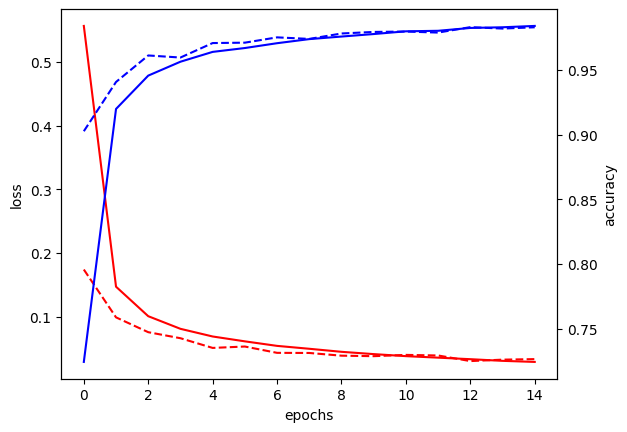

In [25]:
fig, ax1 = plt.subplots()

ax1.set_ylabel('loss', )
ax1.plot(model_wUnc.history.history['loss'], 'r', label='training')
ax1.plot(model_wUnc.history.history['val_loss'], 'r--', label='validation')
ax1.set_xlabel('epochs')

ax2 = ax1.twinx()
ax2.set_ylabel('accuracy', )
ax2.plot(model_wUnc.history.history['accuracy'], 'b', label='training')
ax2.plot(model_wUnc.history.history['val_accuracy'], 'b--', label='validation')

ax2.set_xlabel('epochs')
plt.show()

* Now since the the output of `OneHotCategorical()` is a probability distribution over the categorical classes
* We can calculate the mean and standard deviation, then we can use the standard deviation as upper limit

In [26]:
mean = model_wUnc(example_images).mean().numpy()
stddev = model_wUnc(example_images).stddev().numpy()

In [27]:
mean2 = model_wUnc(example_images).mean().numpy()

In [28]:
(mean == mean2).all()

True

This model remains deterministic; however, by producing a distribution as output, we can account for aleatoric uncertainties. Now, we can use the standard deviation as a metric to assess aleatoric uncertainty in the prediction. A low standard deviation indicates that the values tend to be close to the mean of the set, while a high standard deviation indicates that the values are spread out over a broader range, implying less confidence in the model's prediction

In [29]:
def plot_wstddev(image, mean, stddev):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]}) 
    ax1.imshow(image, cmap='binary')
    ax2.set_xlim(0,9)
    ax2.set_ylim(0,1)
    plt.errorbar(np.arange(10), mean, yerr=stddev, uplims=True, marker='o', linestyle='')
    plt.show()

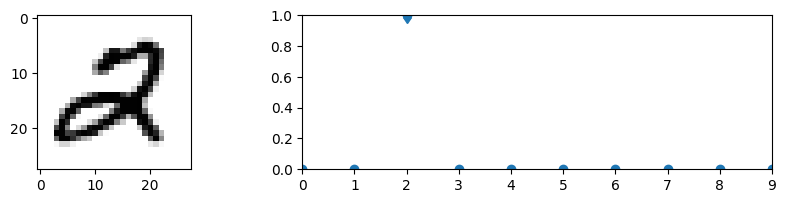

Max value 0.9999369382858276 correspond to this class [2]
error on the class with higher value 0.00794089026749134
this represents a 0.79 % 


In [30]:
plot_wstddev(example_images[0], mean[0], stddev[0])
print(f'Max value {max(mean[0])} correspond to this class {np.where(mean[0] == max(mean[0]))[0]}')
error = stddev[0][np.where(mean[0] == max(mean[0]))[0]][0]
error_per = np.round((error/max(mean[0]))*100.0,2)
print(f'error on the class with higher value {error}\nthis represents a {error_per} % ')

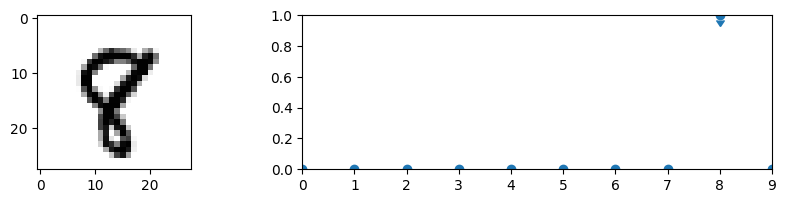

Max value 0.9990264177322388 correspond to this class [8]
error on the class with higher value 0.031187087297439575
this represents a 3.12 % 


In [31]:
plot_wstddev(example_images[122], mean[122], stddev[122])
print(f'Max value {max(mean[122])} correspond to this class {np.where(mean[122] == max(mean[122]))[0]}')
error = stddev[122][np.where(mean[122] == max(mean[122]))[0]][0]
error_per = np.round((error/max(mean[122]))*100.0,2)
print(f'error on the class with higher value {error}\nthis represents a {error_per} % ')

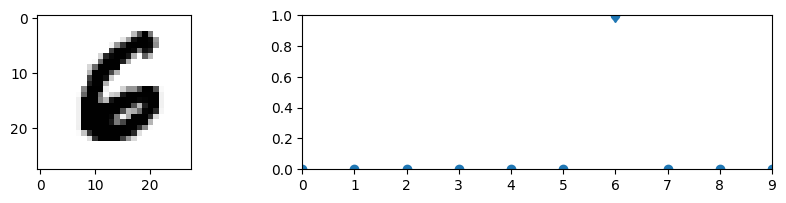

Max value 0.9999974966049194 correspond to this class [6]
error on the class with higher value 0.001582210068590939
this represents a 0.16 % 


In [32]:
plot_wstddev(example_images[5], mean[5], stddev[5])
print(f'Max value {max(mean[5])} correspond to this class {np.where(mean[5] == max(mean[5]))[0]}')
error = stddev[5][np.where(mean[5] == max(mean[5]))[0]][0]
error_per = np.round((error/max(mean[5]))*100.0,2)
print(f'error on the class with higher value {error}\nthis represents a {error_per} % ')

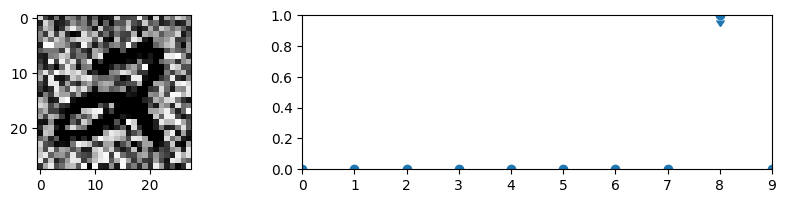

Max value 0.9990335702896118 correspond to this class [8]
error on the class with higher value 0.031072426587343216
this represents a 3.11 % 


In [33]:
mean_wn = model_wUnc(noisy_image.reshape(1,28,28,1)).mean().numpy()
stddev_wn = model_wUnc(noisy_image.reshape(1,28,28,1)).stddev().numpy()
plot_wstddev(noisy_image, mean_wn[0], stddev_wn[0])
print(f'Max value {max(mean_wn[0])} correspond to this class {np.where(mean_wn[0] == max(mean_wn[0]))[0]}')
error = stddev_wn[0][np.where(mean_wn[0] == max(mean_wn[0]))[0]][0]
error_per = np.round((error/max(mean_wn[0]))*100.0,2)
print(f'error on the class with higher value {error}\nthis represents a {error_per} % ')

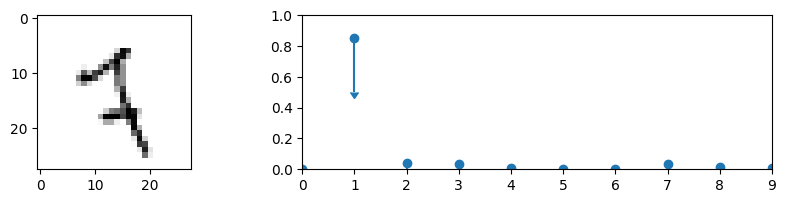

Max value 0.8534542918205261 correspond to this class [1]
error on the class with higher value 0.3536524772644043
this represents a 41.44 % 


In [34]:
plot_wstddev(example_images[33], mean[33], stddev[33])
print(f'Max value {max(mean[33])} correspond to this class {np.where(mean[33] == max(mean[33]))[0]}')
error = stddev[33][np.where(mean[33] == max(mean[33]))[0]][0]
error_per = np.round((error/max(mean[33]))*100.0,2)
print(f'error on the class with higher value {error}\nthis represents a {error_per} % ')

This quantification of aleatoric uncertainties in the predictions enables more informed decision-making

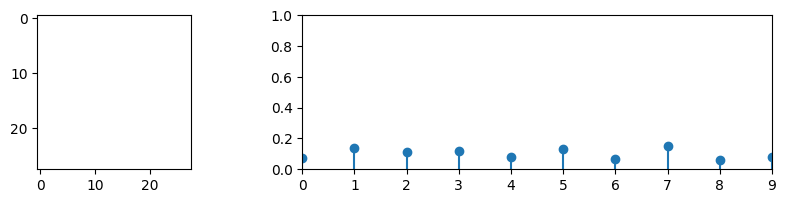

Max value 0.14916370809078217 correspond to this class [7]
error on the class with higher value 0.35624974966049194
this represents a 238.83 % 


In [35]:
mean_zeros = model_wUnc(np.zeros((1,28,28,1))).mean().numpy()
stddev_zeros = model_wUnc(np.zeros((1,28,28,1))).stddev().numpy()
plot_wstddev(np.zeros((1,28,28,1))[0], mean_zeros[0], stddev_zeros[0])
print(f'Max value {max(mean_zeros[0])} correspond to this class {np.where(mean_zeros[0] == max(mean_zeros[0]))[0]}')
error = stddev_zeros[0][np.where(mean_zeros[0] == max(mean_zeros[0]))[0]][0]
error_per = np.round((error/max(mean_zeros[0]))*100.0,2)
print(f'error on the class with higher value {error}\nthis represents a {error_per} % ')